In [1]:
import numpy as np
import patsy

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

# Generate B-spline bases with Scipy
# https://stackoverflow.com/questions/61807542/generate-a-b-spline-basis-in-scipy-like-bs-in-r

First, I use the simple approach of using B-spline bases. Refer to Chapter 5 of Hastie, Tibshirani and Friedman, Elements of Statistical Learning for splines and natural splines. 
Also, see [this primer](https://cran.r-project.org/web/packages/crs/vignettes/spline_primer.pdf) from R `crs`.
Some common notations are: 
1. a B-spline of degree $p$ (polynomials of degree $p$) has order $M = p + 1$. 
2. The basis functions are denoted as $B_{i, p}$ where $i \in 1\ldots D$ is the index of the basis function for degree $p$. 
3. The number of internal knots is denoted by $K$.
4. The number of augmented knots is denoted by $T$.
5. $D = K + m$
6. $T = K + 2m = D + m = D + p + 1$
7. $D$ is also called the degree of freedom.

Properties of B-splines:
1. $B_{i, p}$ is non-zero in the span of $[x_{i}, x_{i+p+1})$, where $x_k$ are the augmented knots.
2. For any knot span $[x_i, x_{i+1})$, there are at most $M = p + 1$ non-zero basis functions $B_{i-p, p}(x) \ldots B_{i, p}(x)$.
3. Number of internal knots: $K = 


Note that in Hastie, Tibshirani, Friedman the Basis functions for degree $p$ and order $M$ are represented as $B_{i, M}$ instead of $B_{i, p}$.

A second-degree or third-order B-spline with $p=2$ and $K=0$ is equivalent to a Bezier curve. It has $D=3$ basis functions or degrees of freedom and $T = 6$.

A third-degree or fourth-order B-spline is commonly called cubic B-spline.

Other references:
1. Chapter 1.4 of [Shape Interrogation for Computer Aided Design and Manufacturing, MIT](http://web.mit.edu/hyperbook/Patrikalakis-Maekawa-Cho/mathe.html)
2. C. K. Shene's Lecture on [Introduction to computing with geometry notes](https://pages.mtu.edu/%7Eshene/COURSES/cs3621/NOTES/) - Unit 6
3. [Knot calculation for spline fitting via sparse optimization](http://staff.ustc.edu.cn/~dengjs/files/papers/knotcal.pdf)
4. [SO: What happens at knots in a cubic spline function?](https://stats.stackexchange.com/questions/421964)
5. [A review of spline function procedures in R](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-019-0666-3)

In [3]:
n = 128
'''
Order of the B-spline is degree + 1
A third-order B-spline (m = 3) is a polynomial of degree two (m − 1 = 2) 
having highest derivative of polynomial degree one (m − 2 = 1).
A third-order or second-degree B-spline with no interior knots
is the same as a quadratic Bezier curve.
A cubic spline is equivalent to a B-spline of degree 3 and order m = 4
'''
degree = 2
# Number of knots on left
kleft = 0
# Number of knots on right
kright = 0
nknots = kleft + kright
std = 0.3

'''
An order m spline with K knots is defined by K + m basis functions.
'''
#btrue = np.array([1.3, 4.5, -1.9, 10.4, 0.6, 6.7, 0.6, 6.7, 2.6])
#btrue = np.array([2, 2, 2])
#btrue = np.array([2, 1, 4])
btrue = np.array([1, -1, 3])

xmin = 0
xmax = 1
xsep = 0.7
x = np.linspace(xmin, xmax, n)
left_knots = np.linspace(xmin, xsep, kleft+2)[1:-1]
right_knots = np.linspace(xsep, xmax, kright+1)[:-1]
knots = np.concatenate((left_knots, right_knots))
bspline_bases = patsy.bs(x, knots = knots, degree = degree, include_intercept=True)

y = np.dot(bspline_bases, btrue) + np.random.normal(0, std, size = n)

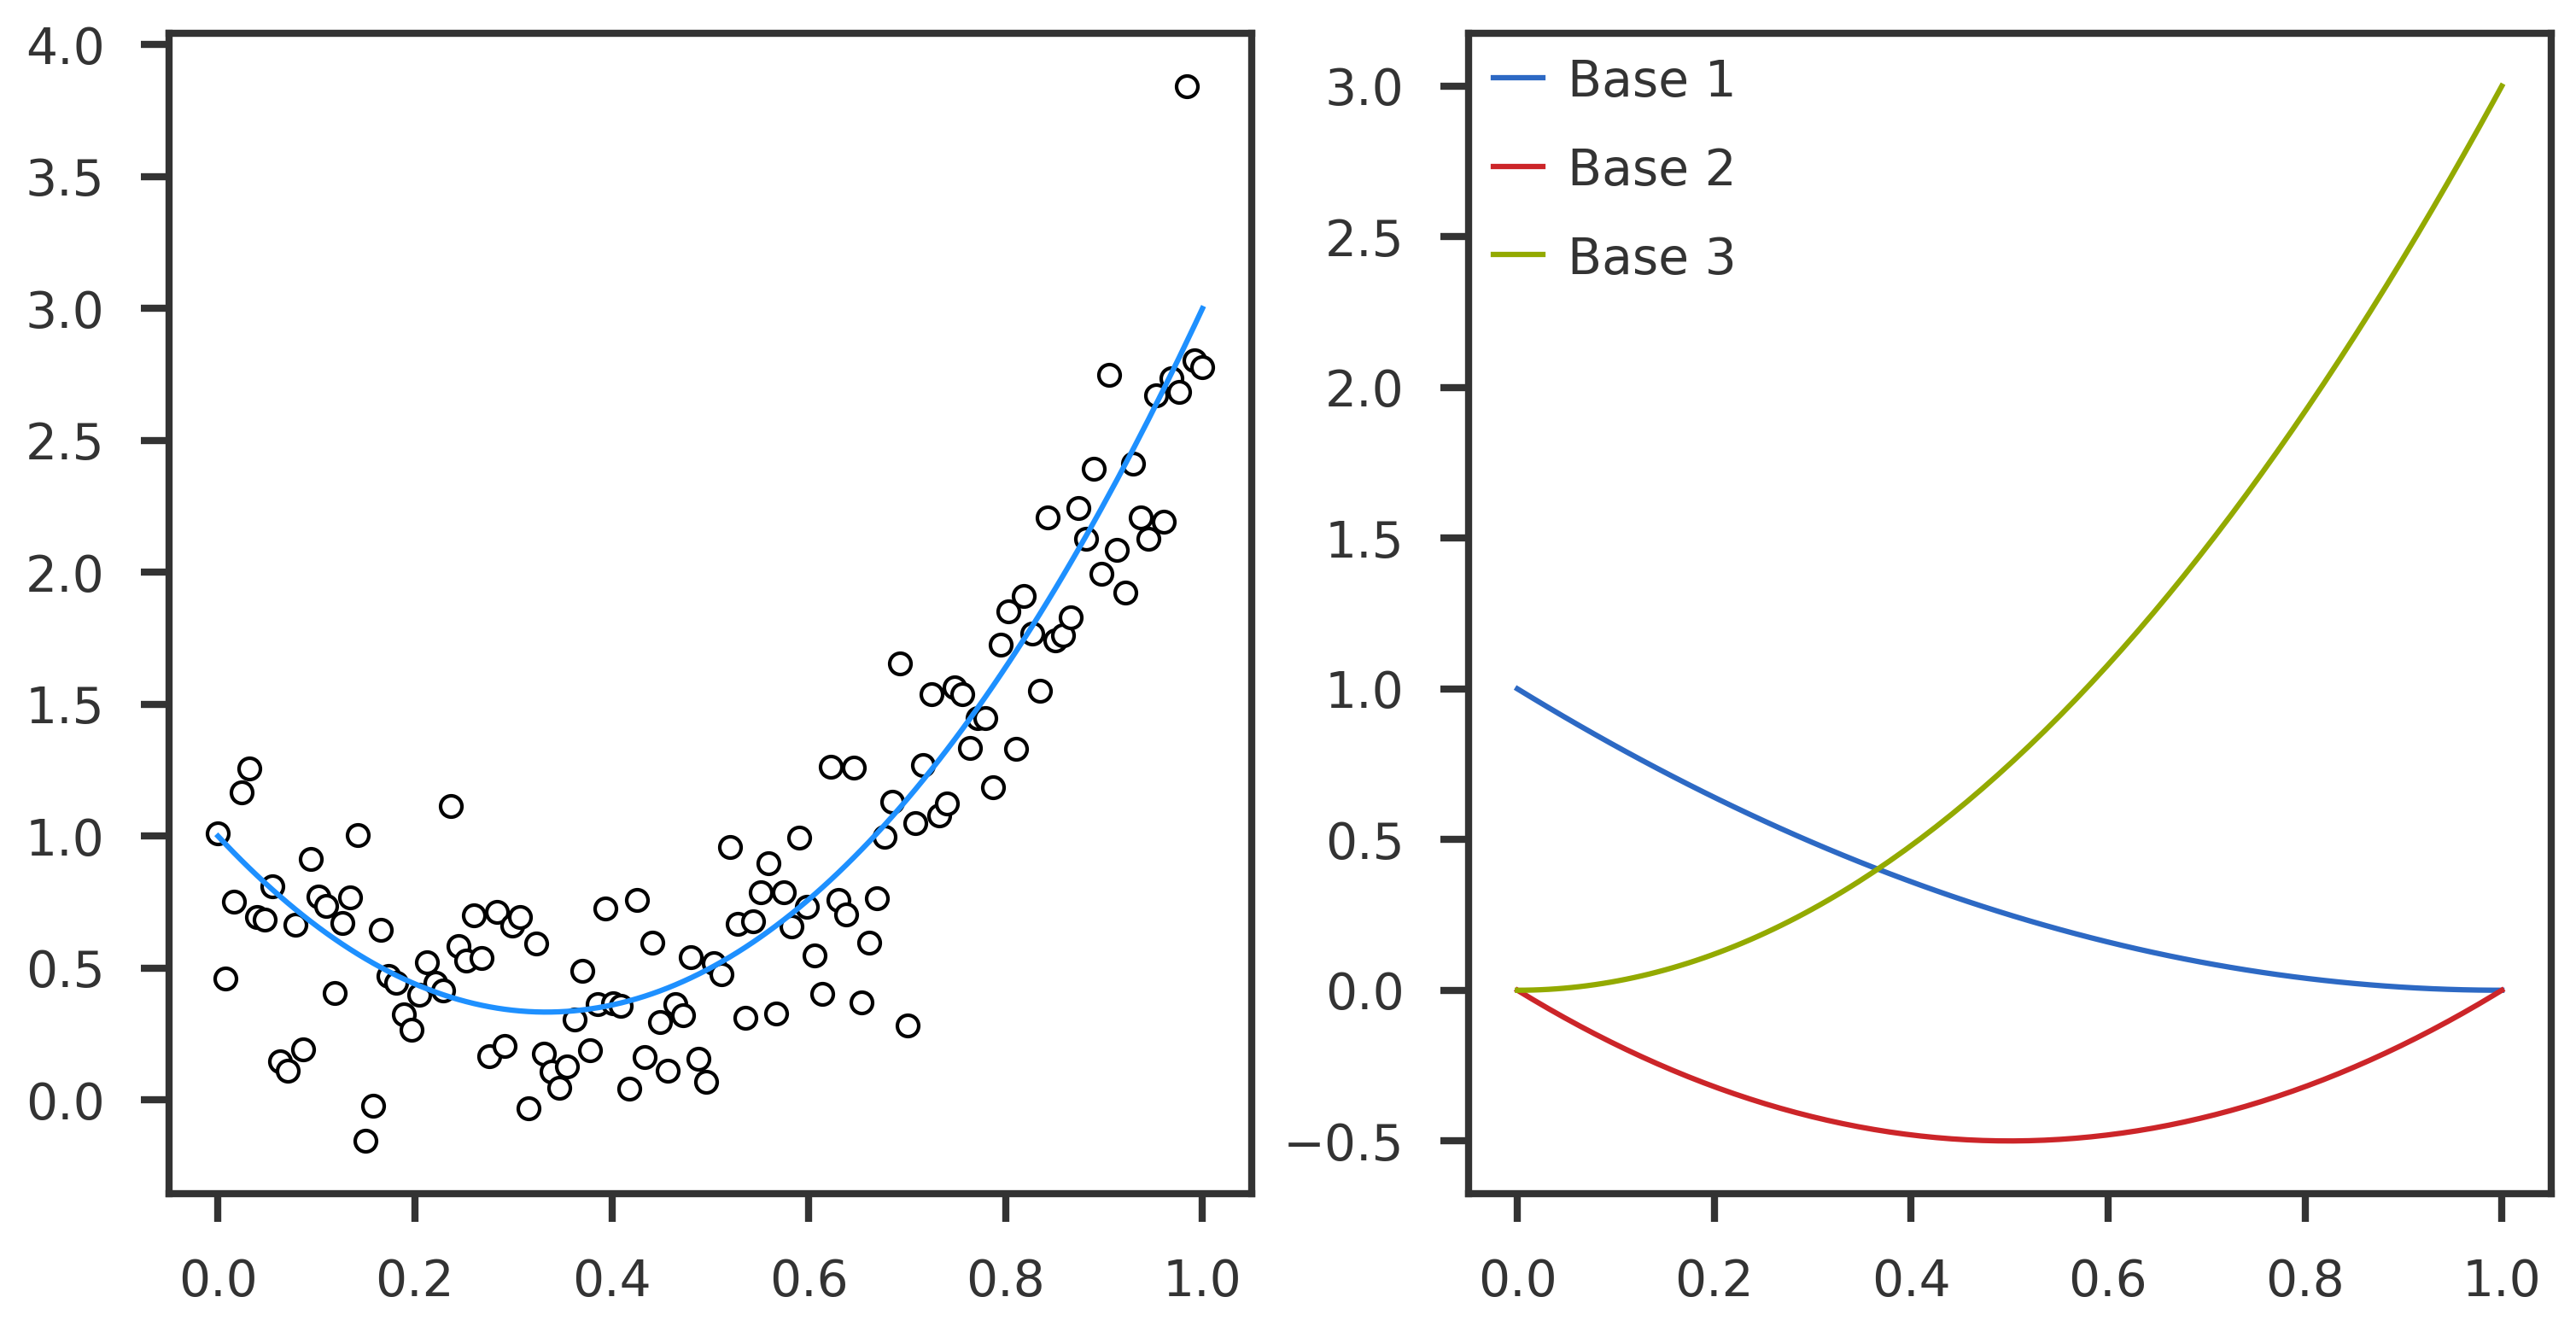

In [4]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(x, y, edgecolor = 'black', facecolor = 'white')
ax1.plot(x, np.dot(bspline_bases, btrue), color = 'dodgerblue')
#ax1.plot(x, bspline_bases * btrue, alpha = 0.1)
for i in range(bspline_bases.shape[1]):
    ax2.plot(x, bspline_bases[:, i] * btrue[i], label = f'Base {i+1}')
ax2.legend()
plt.show()

Next, I want to write the same using a regression:

$y = \beta \mathbf{G}$

One simple way to do it is to generate a $D \times N$ matrix whose each row is B-spline basis function. Since, we have $N$ data points, the maximum number of basis functions that we can use is $D_{\textrm{max}} = N$, corresponding to $K = N-m$ internal knots and $T = N + m$ augmented knots, where $m$ is the order of the B-spline.

For a cubic B-spline, $m=4$ and hence we will specify the location of $N-4$ internal knots.

#### This does not work. See below.

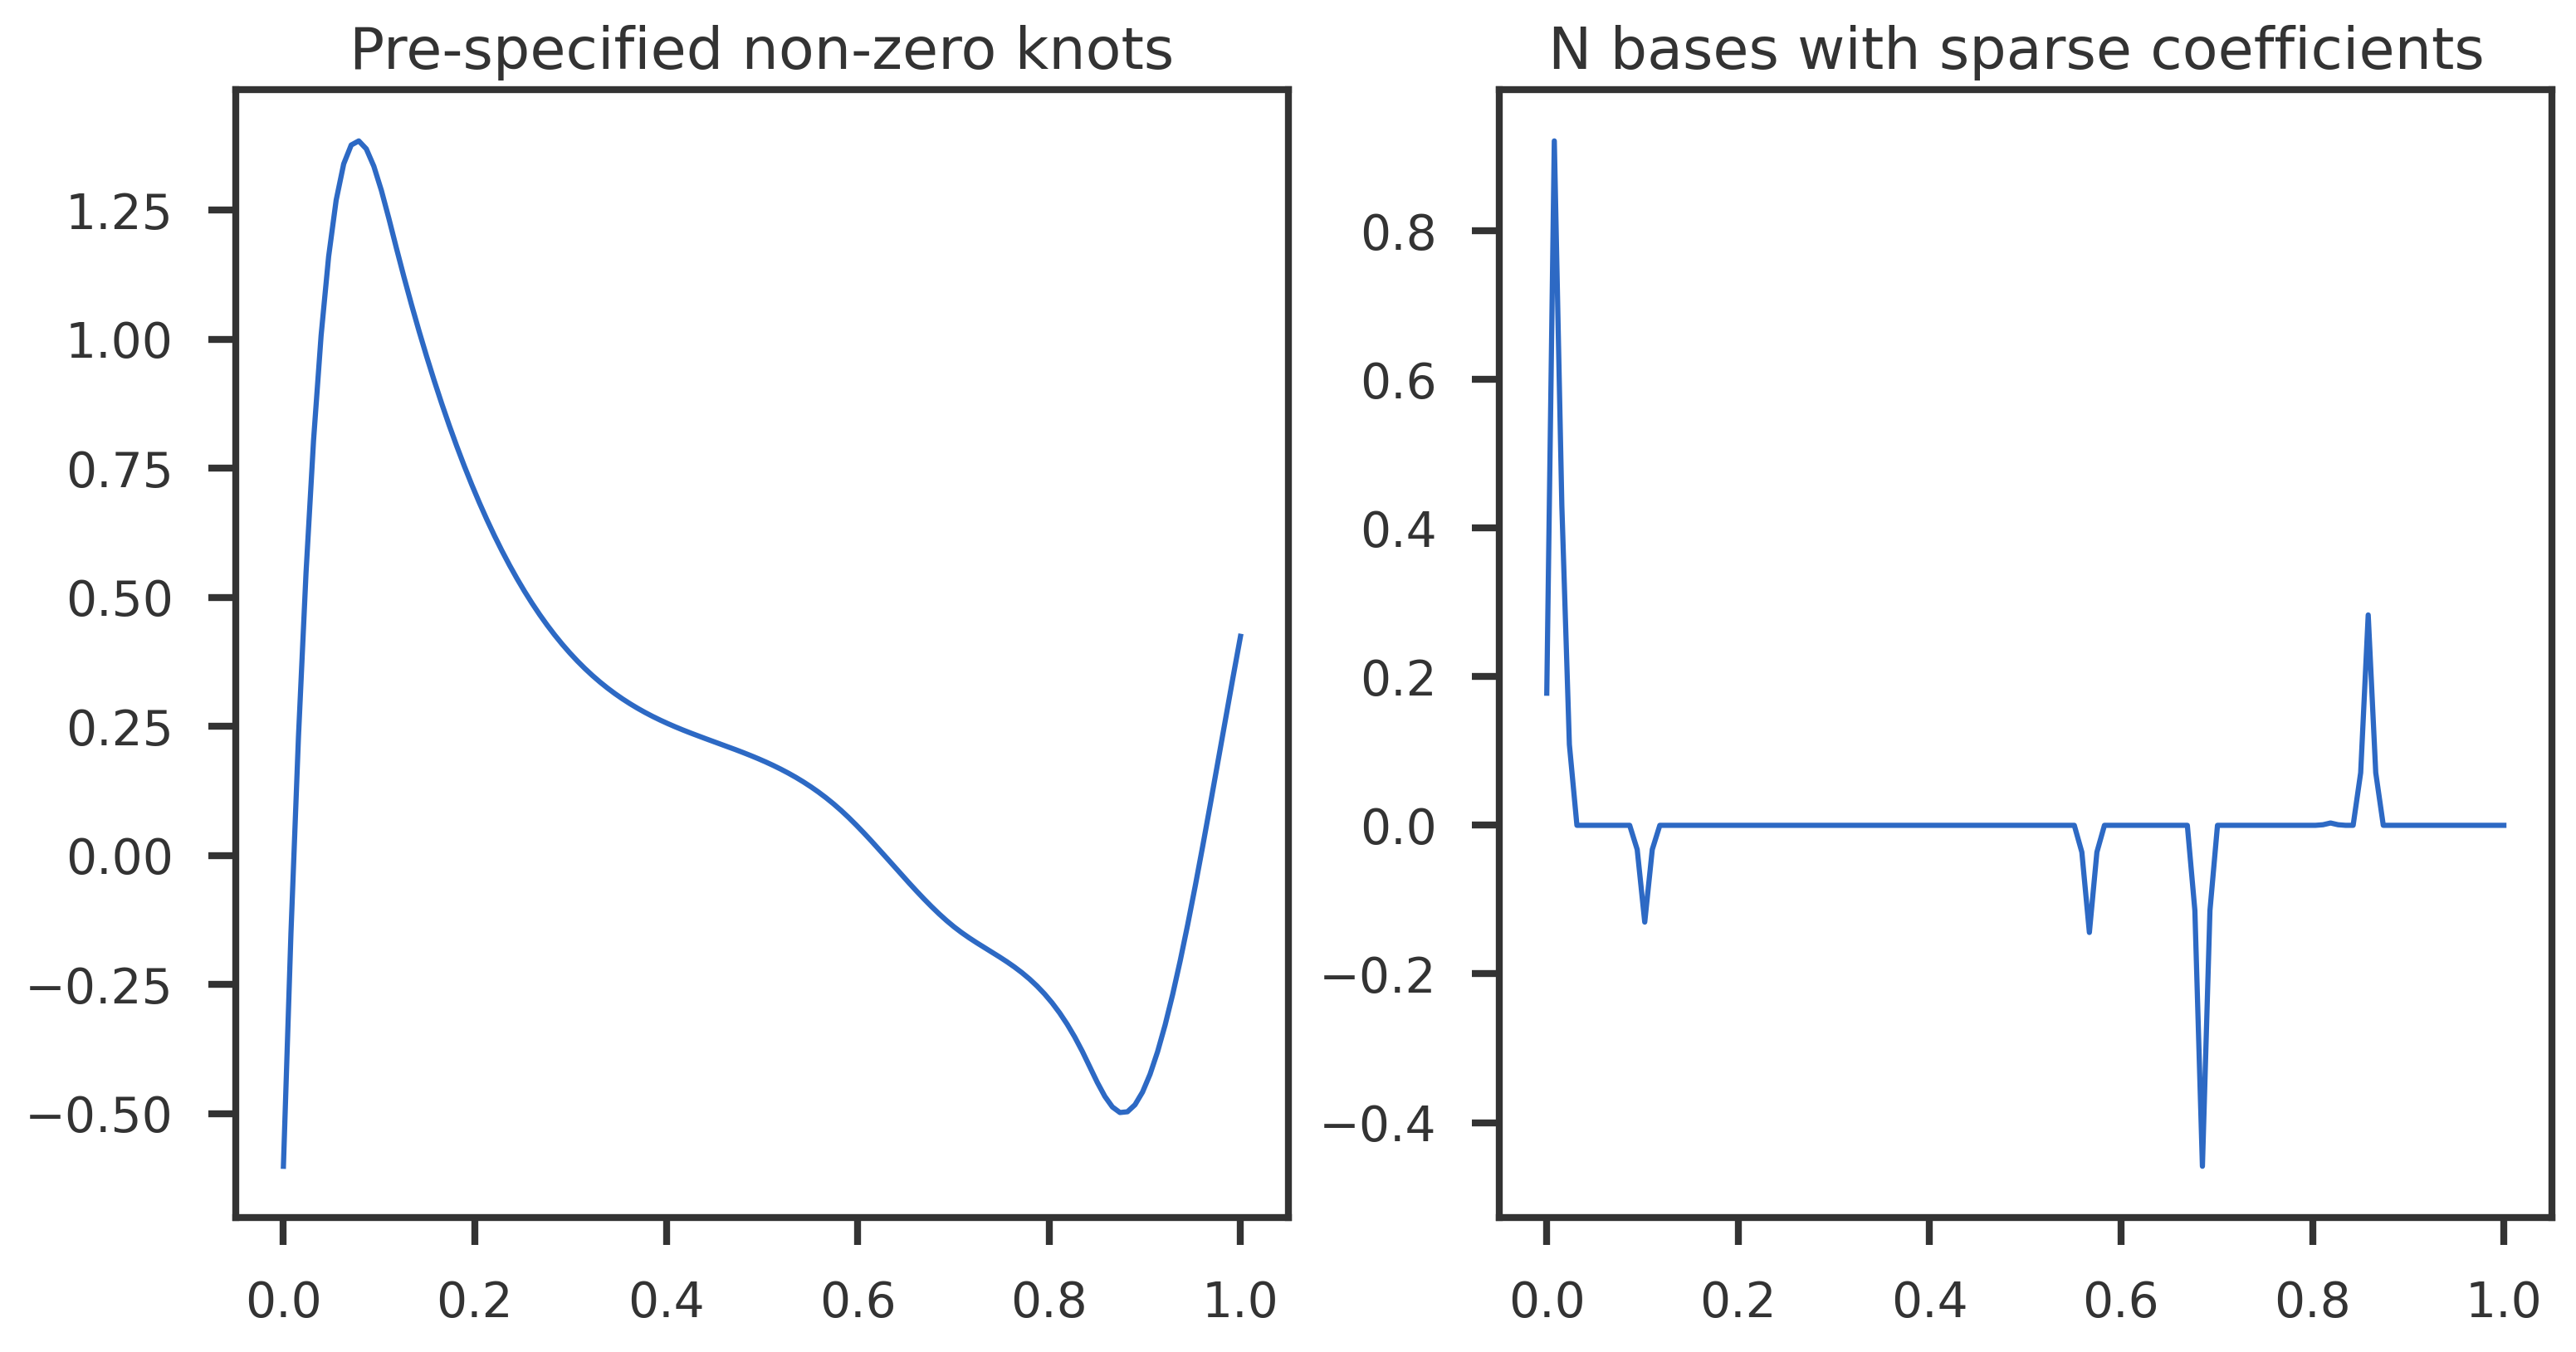

In [66]:
degree = 3
order = 4
K = 5 # number of internal knots
np.random.seed(100)

# All possible knots
knots = np.linspace(xmin, xmax, n)
# Non-zero knots
nz_knots_idx = np.sort(np.random.choice(np.arange(n)[order:], K, replace = False))
# All basis functions
G = patsy.bs(x, knots = knots[order:], degree = degree, include_intercept = True)
# Basis functions with non-zero knots
nz_G = patsy.bs(x, knots = knots[nz_knots_idx], degree = degree, include_intercept = True)
# Sparse coefficients
btrue = np.zeros(n)
nz_btrue = np.random.normal(0, 1, size = K + order)
btrue[:order] = nz_btrue[:order]
btrue[nz_knots_idx] = nz_btrue[order:]

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(x, np.dot(nz_G, nz_btrue))
ax2.plot(x, np.dot(G.T, btrue))

ax1.set_title("Pre-specified non-zero knots")
ax2.set_title("N bases with sparse coefficients ")

plt.show()

## Trendfiltering

Here, I explore the trendfiltering basis
The idea is to 
1. generate the "hills" example using B-spline, 
2. solve it using trendfiltering, 
3. do a variable transformation to find the coefficients of TF basis (H, defined by Tibshirani) and 
4. compare $\beta$ with $H\alpha$.

### Hills example data

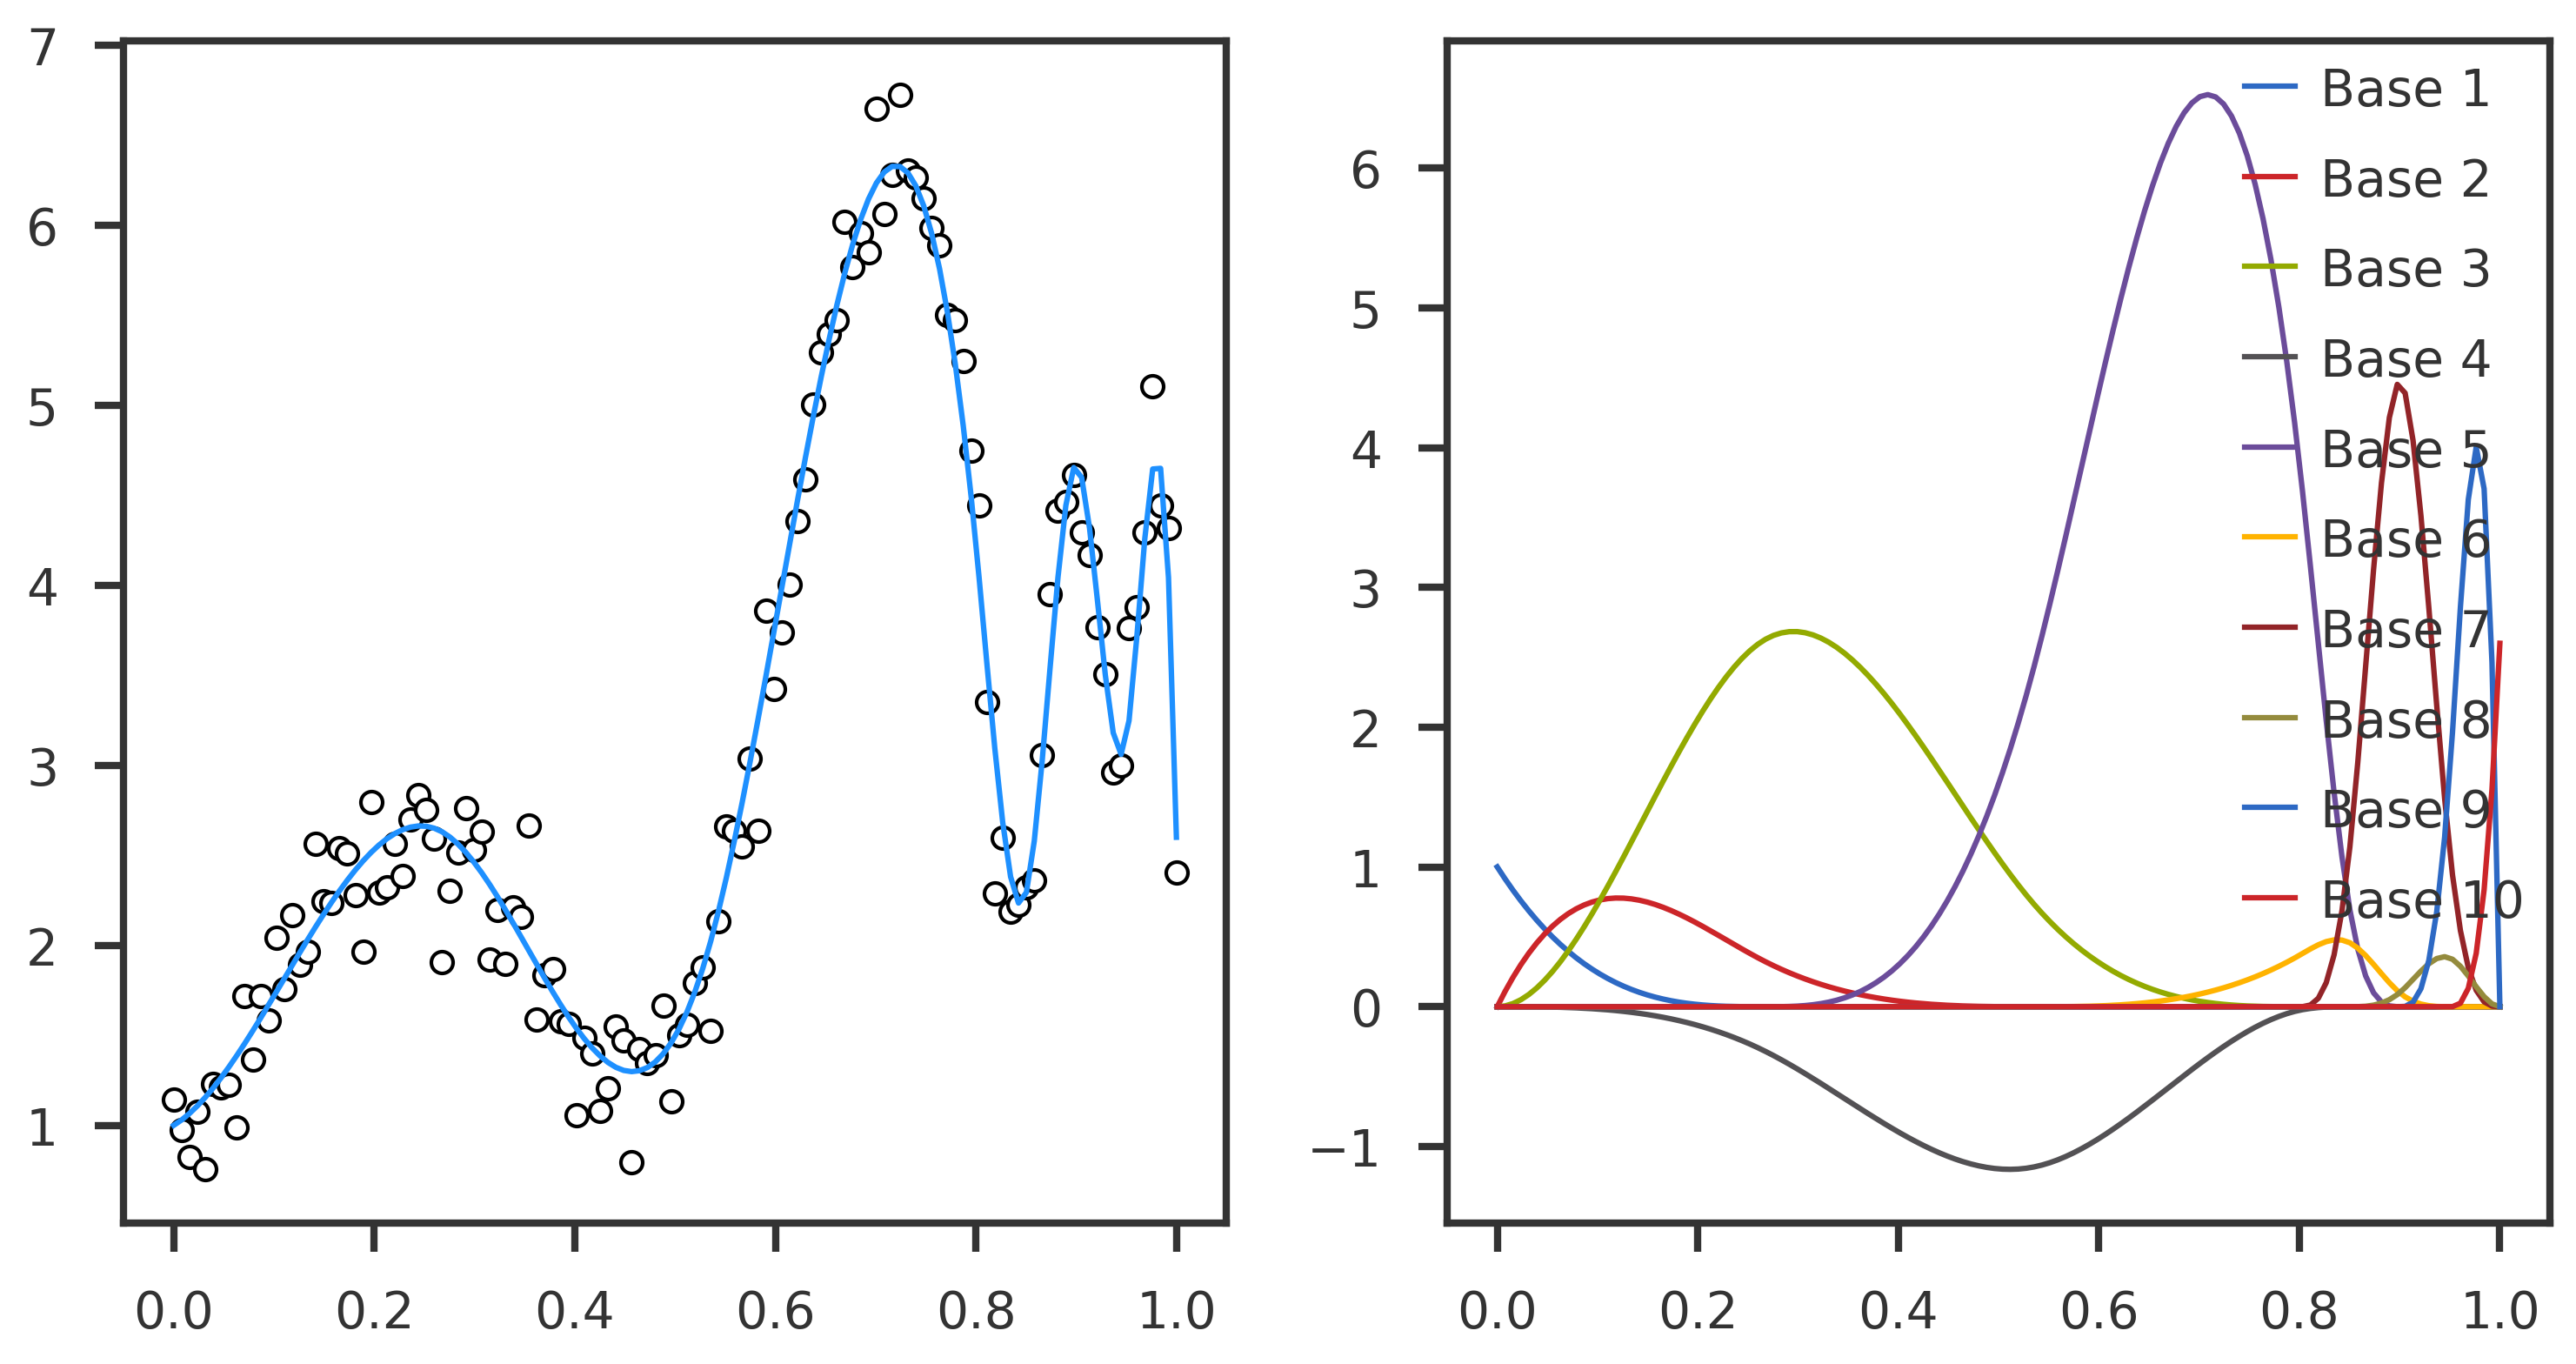

In [184]:
n = 128
degree = 3
order = 4

# Number of knots on left
kleft = 2
# Number of knots on right
kright = 4
nknots = kleft + kright
std = 0.3

'''
An order m spline with K knots is defined by K + m basis functions.
'''
btrue = np.array([1.0, 1.3, 4.5, -1.9, 10.4, 0.6, 6.7, 0.6, 6.7, 2.6])

xmin = 0
xmax = 1
xsep = 0.8
x = np.linspace(xmin, xmax, n)
left_knots = np.linspace(xmin, xsep, kleft+2)[1:-1]
right_knots = np.linspace(xsep, xmax, kright+1)[:-1]
knots = np.concatenate((left_knots, right_knots))
bspline_bases = patsy.bs(x, knots = knots, degree = degree, include_intercept=True)

y = np.dot(bspline_bases, btrue) + np.random.normal(0, std, size = n)

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(x, y, edgecolor = 'black', facecolor = 'white')
ax1.plot(x, np.dot(bspline_bases, btrue), color = 'dodgerblue')
#ax1.plot(x, bspline_bases * btrue, alpha = 0.1)
for i in range(bspline_bases.shape[1]):
    ax2.plot(x, bspline_bases[:, i] * btrue[i], label = f'Base {i+1}')
ax2.legend()
plt.show()

### Solve with R trendfiltering

In [119]:
def discrete_difference_operator(n, k):
    '''
    Returns D(k)
    '''
    if k == 0:
        D = np.eye(n)
    else:
        # define D(1)
        D = np.zeros((n-1, n))
        for i in range(n-1):
            D[i, i] = -1
            D[i, i+1] = 1
        D1 = D.copy()
        for j in range(1, k):
            Dj = D.copy()
            D = np.dot(D1[:n-j-1, :n-j], Dj)
    return D
    

# def trendfitering_basis()
discrete_difference_operator(10, 4).shape

(6, 10)

In [157]:
n = 128
K = 3
DK = discrete_difference_operator(n, K + 1)
Minv = np.zeros((n, n))
for i in range(K + 1):
    print(i)
    Di = discrete_difference_operator(n, i)
    Minv[i, :] = Di[0, :]
Minv[i+1:, :] = DK

def Dinv(n, k):
    def getM(n, i):
        M = np.zeros((n, n))
        M[:i, :i] = np.eye(i)
        M[i:, i:] = np.tril(np.ones((n-i, n-i)))
        return M
    M = getM(n, 0)
    for i in range(1, k+1):
        M = np.dot(M, getM(n, i))
    return M

0
1
2
3


In [169]:
np.where(np.abs(Dinv(n, K) - np.linalg.inv(Minv)) > 0.0001)

(array([], dtype=int64), array([], dtype=int64))

In [170]:
def trendfiltering_basis(n, k):
    H = np.zeros((n, n))
    for j in range(k+1):
        for i in range(n):
            H[i, j] = np.power(i+1, j) / np.power(n, j)
    for j in range(k+1, n):
        for i in range(n):
            if i > j - 1:
                Hij = 1.0
                for l in range(1, k+1):
                    Hij *= (i - j + k - l + 1) / np.power(n, k)
                H[i, j] = Hij
    return H

In [176]:
H = trendfiltering_basis(n, 1)

In [177]:
H.shape

(128, 128)

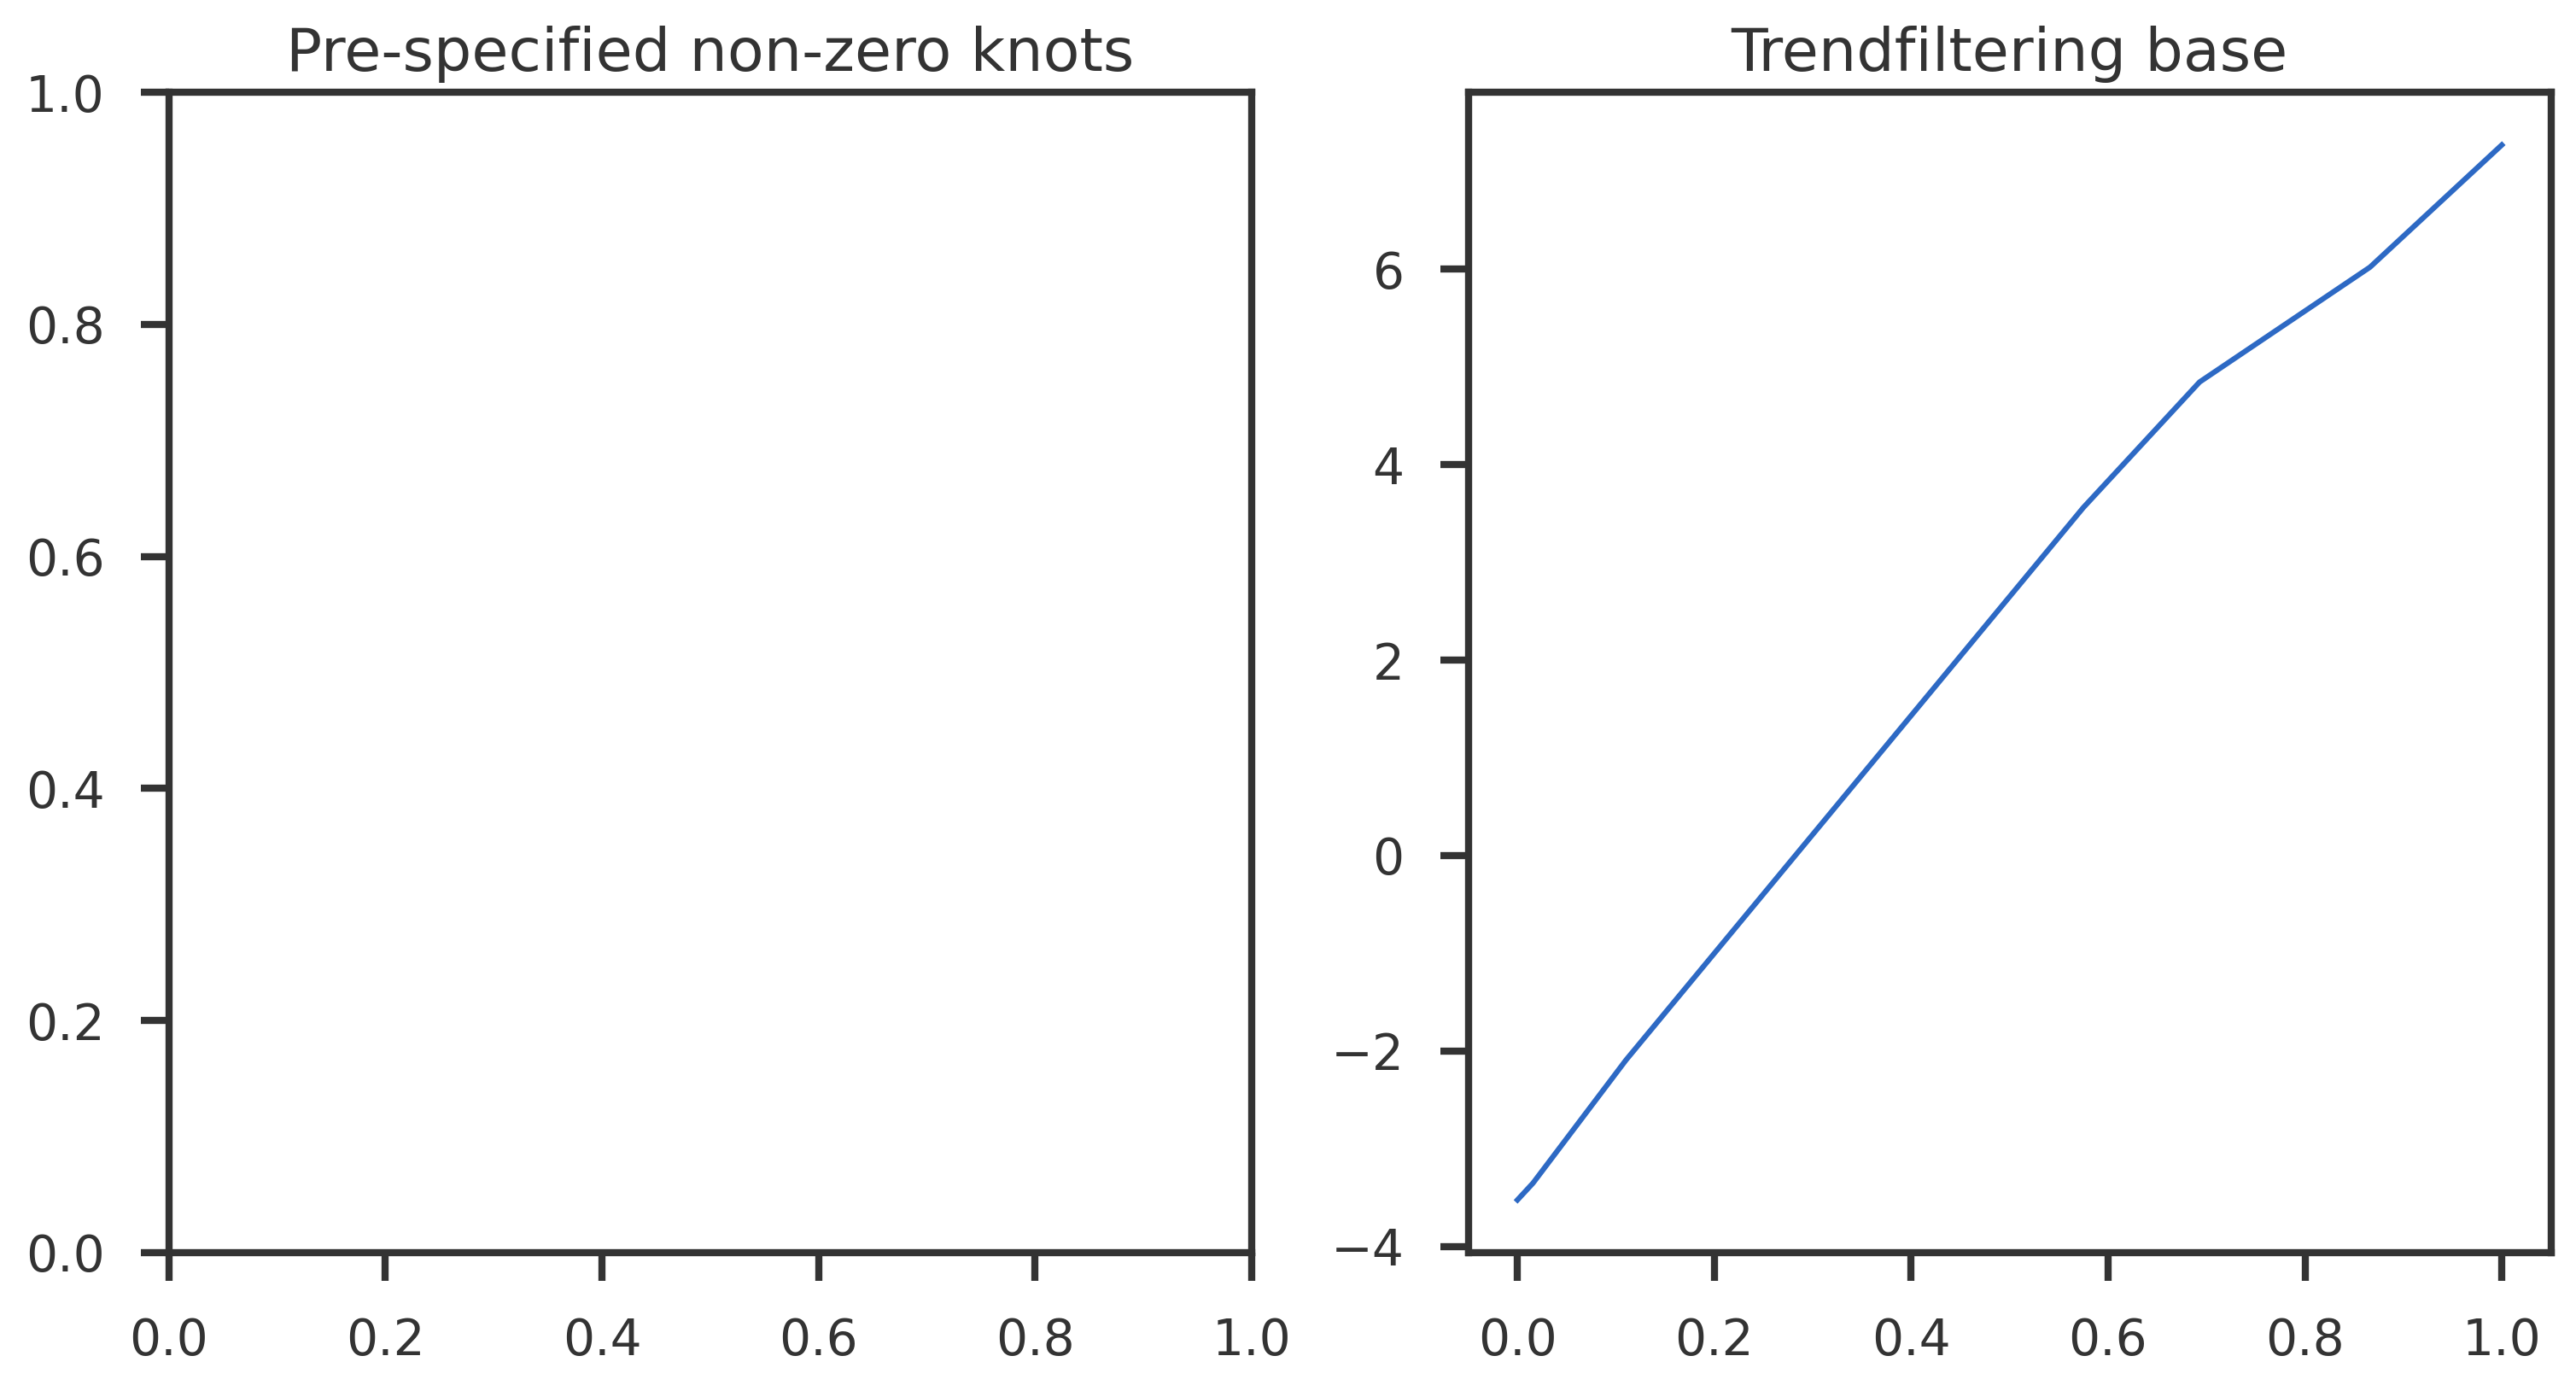

In [180]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


ax2.plot(x, np.dot(H, btrue* 6))

ax1.set_title("Pre-specified non-zero knots")
ax2.set_title("Trendfiltering base")

plt.show()